![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor
**По ходу задачи:**
* Прокачаем работу с pandas
* Научимся работать с Kaggle Notebooks
* Поймем как делать предобработку различных данных
* Научимся работать с пропущенными данными (Nan)
* Познакомимся с различными видами кодирования признаков
* Немного попробуем [Feature Engineering](https://ru.wikipedia.org/wiki/Конструирование_признаков) (генерировать новые признаки)
* И совсем немного затронем ML
* И многое другое...   



### И самое важное, все это вы сможете сделать самостоятельно!

*Этот Ноутбук являетсся Примером/Шаблоном к этому соревнованию (Baseline) и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.

> что такое baseline решение, зачем оно нужно и почему предоставлять baseline к соревнованию стало важным стандартом на kaggle и других площадках.   
**baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой, просто для примера. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline являеться хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

В контексте нашего соревнования baseline идет с небольшими примерами того, что можно делать с данными, и с инструкцией, что делать дальше, чтобы улучшить результат.  Вообще готовым решением это сложно назвать, так как используются всего 2 самых простых признака (а остальные исключаются).

# Подготовка
## 1. import

In [375]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option('display.max.columns', 100)

import re # for strings processing
import json
from pprint import pprint

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
os_files = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        file = os.path.join(dirname, filename)
        print(file)
        os_files.append(file)

# Any results you write to the current directory are saved as output.

/kaggle/input/tripadviso-parsing/parsed_data_output_new.json
/kaggle/input/tripadviso-parsing/country_data.json
/kaggle/input/tripadviso-parsing/currency_rates.json
/kaggle/input/tripadviso-parsing/city_data.json
/kaggle/input/tripadviso-parsing/data_scraping.py
/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv


In [376]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [377]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

## 2. Функции для предобработки

In [444]:
def round_of_rating(number):
    return np.round(number * 2) / 2

In [379]:
# заполнение спарсенными данными колонок Cuisine Style, Price Range, Number of Reviews

def fillna_parsed(row, obj):
    if pd.isna(row[obj]):
        rest_id = row['Restaurant_id']
        rest_url = row['URL_TA']
        parsed_values = parsed_data.loc[(parsed_data['Restaurant_id'] == rest_id) & (parsed_data['URL_TA'] == rest_url), obj]
        print(rest_id, rest_url, parsed_values.shape[0]) if parsed_values.shape[0] > 1 else None
        return parsed_values.iloc[0] if parsed_values.shape[0] == 1 else None
    else:
        return row[obj]


# mn = data.apply(fillna_parsed, obj='Cuisine Style', axis=1)

In [380]:
def cuisine_notna_dummies(styles, current):
    return (0 if pd.isnull(styles)
            else int(current in styles))
    
    
def cuisine_dummies(data):
    pat = re.compile('\'(.*?)\'')
    cuisine_styles = data['Cuisine Style'].dropna().str.findall('\'(.*?)\'')
    unique_cuisine_styles = np.sort(cuisine_styles.explode().unique())

    for cuisine in unique_cuisine_styles:
        cuisine_prefixed = f'Cuisine_{cuisine}'
        data[cuisine_prefixed] = data['Cuisine Style'].apply(cuisine_notna_dummies, current=cuisine)

    data['Cuisine_nan'] = pd.isna(data['Cuisine Style']).astype('uint8')   # if cuisines in strings
    
    return data

In [381]:
def get_weighed_rank(row, obj, rank_table):
    city = row['City']
    value = row[obj]
    return value / rank_table.loc[city]

In [382]:
def custom_fillna(row, obj, table):
    return table[row['City']] if pd.isna(row[obj]) else row[obj]

## 3. Загрузка данных
### Внешние

In [383]:
# скрипт с загрузкой внешних данных - см draft.py на github

DATA_DIR = '/kaggle/input/'
countries_info = pd.read_json(DATA_DIR+'tripadviso-parsing/country_data.json', orient='records')

# no Italy in this dataset
cities_info = pd.read_json(DATA_DIR+'tripadviso-parsing/city_data.json', orient='index')

with open(DATA_DIR+'tripadviso-parsing/currency_rates.json', 'r') as file:
    currency_rates = json.load(file)

In [384]:
countries_info['currency'] = countries_info['currencies'].astype('str').str.slice(start=11, stop=14)
countries_info['currency rate'] = countries_info['currency'].apply(lambda x: currency_rates['rates'][x])
countries_info['alpha2Code'] = countries_info['alpha2Code'].str.lower()

# оставляем только данные, которым пока нашли применение (как пользоваться остальными, возм, придумаем позже):
countries_info = countries_info[['name', 'alpha2Code', 'capital', 'subregion', 'population', 'area', 'gini', 'borders', 'currency', 'currency rate']]
countries_info.columns = ['country', 'alpha2Code', 'capital', 'subregion', 'population', 'area', 'gini', 'borders', 'currency', 'currency rate']
countries_info.sample(5)

,country,alpha2Code,capital,subregion,population,area,gini,borders,currency,currency rate
51,Ukraine,ua,Kiev,Eastern Europe,42692393,603700.0,26.4,"[BLR, HUN, MDA, POL, ROU, RUS, SVK]",UAH,26.723859
13,Faroe Islands,fo,Tórshavn,Northern Europe,49376,1393.0,NaN,[],DKK,7.470602
2,Andorra,ad,Andorra la Vella,Southern Europe,78014,468.0,NaN,"[FRA, ESP]",EUR,1.000000
39,Portugal,pt,Lisbon,Southern Europe,10374822,92090.0,38.5,[ESP],EUR,1.000000
12,Estonia,ee,Tallinn,Northern Europe,1315944,45227.0,36.0,"[LVA, RUS]",EUR,1.000000


In [385]:
cities_info.reset_index(inplace=True)
cities_info.drop(['accentcity', 'city', 'geopoint'], axis=1, inplace=True)
cities_info.columns = ['City', 'alpha2Code', 'latitude', 'longitude', 'population', 'region']
cities_info.loc[cities_info['City'] == 'Krakow', 'population'] = 768731
cities_info.loc[cities_info['City'] == 'Luxembourg', 'population'] = 630703
cities_info.loc[cities_info['City'] == 'Oporto', 'population'] = 1312947
cities_info.sample(5)

,City,alpha2Code,latitude,longitude,population,region
27,Stockholm,se,59.333333,18.050000,1253309.0,26
20,Milan,it,45.466667,9.200000,1156903.0,09
8,Dublin,ie,53.333056,-6.248889,1024027.0,07
26,Rome,it,41.900000,12.483333,2643736.0,07
24,Paris,fr,48.866667,2.333333,2110694.0,A8


In [386]:
# parsed_data = pd.read_json(DATA_DIR+'tripadviso-parsing/parsed_data_output_new.json', orient='index')
# display(parsed_data.head(5))
# parsed_data.info()

### Данные задачи

In [387]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [388]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [389]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [390]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
Restaurant_id        10000 non-null object
City                 10000 non-null object
Cuisine Style        7693 non-null object
Ranking              10000 non-null float64
Price Range          6525 non-null object
Number of Reviews    9343 non-null float64
Reviews              9998 non-null object
URL_TA               10000 non-null object
ID_TA                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [391]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [392]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [393]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
Restaurant_id    10000 non-null object
Rating           10000 non-null float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [394]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [395]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [396]:
print(df_train['Restaurant_id'].nunique(), 'уникальных из 40 000')
print(df_test['Restaurant_id'].nunique(), 'уникальных из 10 000')
print(data['Restaurant_id'].nunique(), 'уникальных из 50 000')
print('т.е. в трейне и тесте id повторяются')

11909 уникальных из 40 000
10000 уникальных из 10 000
13094 уникальных из 50 000
т.е. в трейне и тесте id повторяются


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [397]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
26036,id_734,Dublin,"['Asian', 'Vegetarian Friendly']",735.0,$,25.0,"[['Fantastic!', 'Terrific'], ['11/07/2017', '1...",/Restaurant_Review-g186605-d11612437-Reviews-H...,d11612437,1,4.5
6176,id_6176,Zurich,"['Cafe', 'European', 'French']",764.0,$$ - $$$,37.0,"[['Soak up the sun at the neighbourhood cafe',...",/Restaurant_Review-g188113-d4309028-Reviews-Ca...,d4309028,0,0.0
42715,id_779,Vienna,"['Austrian', 'European', 'Central European', '...",780.0,$$ - $$$,85.0,"[['Lunch with my colleagues', 'An authentic ta...",/Restaurant_Review-g190454-d1996301-Reviews-Ga...,d1996301,1,4.0
34969,id_840,Brussels,"['American', 'Bar', 'Pub']",841.0,$,21.0,"[[], []]",/Restaurant_Review-g1136495-d1911219-Reviews-T...,d1911219,1,4.5
29704,id_754,Brussels,['Cafe'],755.0,$$ - $$$,17.0,"[['A friendly and cozy place !', 'Coffee and c...",/Restaurant_Review-g188644-d10264688-Reviews-L...,d10264688,1,4.5


In [398]:
data.Reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

# Cleaning and Prepping Data
Обычно данные содержат в себе кучу мусора, который необходимо почистить, для того чтобы привести их в приемлемый формат. Чистка данных — это необходимый этап решения почти любой реальной задачи.   
![](https://analyticsindiamag.com/wp-content/uploads/2018/01/data-cleaning.png)

## 1. Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

In [399]:
# заполнение спарсенными данными - проводить не будем, не улучшает результат; возможно, тк в трейне и тесте URL_TA не повторяются:
# mn = data.apply(fillna_parsed, obj='Cuisine Style', axis=1)

In [400]:
# Для примера я возьму столбец Number of Reviews + Price Range
data['Number_of_Reviews_isNAN'] = pd.isna(data['Number of Reviews']).astype('uint8')
data['Price_Range_isNAN'] = pd.isna(data['Price Range']).astype('uint8')
data[['Number_of_Reviews_isNAN', 'Price_Range_isNAN']].sample(5)

,Number_of_Reviews_isNAN,Price_Range_isNAN
45611,0,0
7717,0,0
30185,0,0
22965,0,0
1588,0,0


In [401]:
# Далее заполняем пропуски 0, вы можете попробовать заполнением средним или средним по городу и тд...
data['Number of Reviews'].fillna(0, inplace=True)

In [402]:
# пропуски в Price Range заполним самым встречающимся по городу:

city_ranges = data['City'].value_counts()

for city in city_ranges.index:
    city_ranges[city] = data[data['City'] == city]['Price Range'].value_counts().idxmax()

print(city_ranges)

London        $$ - $$$
Paris         $$ - $$$
Madrid        $$ - $$$
Barcelona     $$ - $$$
Berlin        $$ - $$$
Milan         $$ - $$$
Rome          $$ - $$$
Prague        $$ - $$$
Lisbon        $$ - $$$
Vienna        $$ - $$$
Amsterdam     $$ - $$$
Brussels      $$ - $$$
Hamburg       $$ - $$$
Munich        $$ - $$$
Lyon          $$ - $$$
Stockholm     $$ - $$$
Budapest      $$ - $$$
Warsaw        $$ - $$$
Dublin        $$ - $$$
Copenhagen    $$ - $$$
Athens        $$ - $$$
Edinburgh     $$ - $$$
Zurich        $$ - $$$
Oporto        $$ - $$$
Geneva        $$ - $$$
Krakow        $$ - $$$
Oslo          $$ - $$$
Helsinki      $$ - $$$
Bratislava    $$ - $$$
Luxembourg    $$ - $$$
Ljubljana     $$ - $$$
Name: City, dtype: object


In [403]:
# выше видно, что среднее по всем городам одинаковое, поэтому пропуски заполним константой:
data['Price Range'].fillna('$$ - $$$', inplace=True)

In [404]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
Restaurant_id              50000 non-null object
City                       50000 non-null object
Cuisine Style              38410 non-null object
Ranking                    50000 non-null float64
Price Range                50000 non-null object
Number of Reviews          50000 non-null float64
Reviews                    49998 non-null object
URL_TA                     50000 non-null object
ID_TA                      50000 non-null object
sample                     50000 non-null int64
Rating                     50000 non-null float64
Number_of_Reviews_isNAN    50000 non-null uint8
Price_Range_isNAN          50000 non-null uint8
dtypes: float64(3), int64(1), object(7), uint8(2)
memory usage: 4.3+ MB


### 2. Обработка признаков
Для начала посмотрим какие признаки у нас могут быть категориальными.

In [405]:
data.nunique(dropna=False)

Restaurant_id              13094
City                          31
Cuisine Style              10732
Ranking                    12975
Price Range                    3
Number of Reviews           1574
Reviews                    41858
URL_TA                     49963
ID_TA                      49963
sample                         2
Rating                        10
Number_of_Reviews_isNAN        2
Price_Range_isNAN              2
dtype: int64

Какие признаки можно считать категориальными?

Для кодирования категориальных признаков есть множество подходов:
* Label Encoding
* One-Hot Encoding
* Target Encoding
* Hashing

Выбор кодирования зависит от признака и выбраной модели.
Не будем сейчас сильно погружаться в эту тематику, давайте посмотрим лучше пример с One-Hot Encoding:
![](https://i.imgur.com/mtimFxh.png)

In [406]:
# для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
data = pd.get_dummies(data, columns=['City'], dummy_na=True)

In [407]:
data.sample(5)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,Number_of_Reviews_isNAN,Price_Range_isNAN,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,City_Brussels,City_Budapest,City_Copenhagen,City_Dublin,City_Edinburgh,City_Geneva,City_Hamburg,City_Helsinki,City_Krakow,City_Lisbon,City_Ljubljana,City_London,City_Luxembourg,City_Lyon,City_Madrid,City_Milan,City_Munich,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
20064,id_2999,['Cafe'],3001.0,$$ - $$$,50.0,"[['Four restaurants in large area', 'Nice Atmo...",/Restaurant_Review-g190454-d694350-Reviews-Caf...,d694350,1,3.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
18060,id_6005,"['Italian', 'Cafe', 'Mediterranean']",6008.0,$,59.0,"[['Well, pizza was allright...', 'Nice little ...",/Restaurant_Review-g187849-d2718680-Reviews-Br...,d2718680,1,2.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
6781,id_6781,"['Bar', 'British', 'Pub', 'International', 'Ga...",5652.0,$$ - $$$,146.0,"[['Great hospitality', 'Christmas Office lunch...",/Restaurant_Review-g186338-d2440764-Reviews-Th...,d2440764,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8557,id_8557,"['French', 'European', 'Vegetarian Friendly']",1030.0,$$ - $$$,202.0,[['Beautiful little restaurant for Steak Frit....,/Restaurant_Review-g187147-d4597792-Reviews-Po...,d4597792,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
35155,id_1419,"['Austrian', 'Bar', 'European', 'Pub', 'Diner']",1420.0,$$ - $$$,20.0,"[['Excellent!!!', 'Last minute decision, pleas...",/Restaurant_Review-g190454-d7159987-Reviews-Ga...,d7159987,1,4.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


#### Возьмем следующий признак "Price Range".

In [408]:
data['Price Range'].value_counts()

$$ - $$$    40402
$            7816
$$$$         1782
Name: Price Range, dtype: int64

По описанию 'Price Range' это - Цены в ресторане.  
Их можно поставить по возрастанию (значит это не категориальный признак). А это значит, что их можно заменить последовательными числами, например 1,2,3  
*Попробуйте сделать обработку этого признака уже самостоятельно!*

In [409]:
price_ranges = {np.nan: 0, '$': 1, '$$ - $$$': 2, '$$$$': 3}
data['Price Range'] = data['Price Range'].apply(lambda x: price_ranges[x])

In [410]:
data['Price Range'].describe()

count    50000.000000
mean         1.879320
std          0.421189
min          1.000000
25%          2.000000
50%          2.000000
75%          2.000000
max          3.000000
Name: Price Range, dtype: float64

> Для некоторых алгоритмов МЛ даже для не категориальных признаков можно применить One-Hot Encoding, и это может улучшить качество модели. Пробуйте разные подходы к кодированию признака - никто не знает заранее, что может взлететь.

### Обработать другие признаки вы должны самостоятельно!
Для обработки других признаков вам возможно придется даже написать свою функцию, а может даже и не одну, но в этом и есть ваша практика в этом модуле!     
Следуя подсказкам в модуле вы сможете более подробно узнать, как сделать эти приобразования.

In [411]:
# тут ваш код на обработку других признаков
# .....

![](https://cs10.pikabu.ru/post_img/2018/09/06/11/1536261023140110012.jpg)

1. Cuisine Style

In [412]:
# data = cuisine_dummies(data)
# data.sample(3)

# EDA 
[Exploratory Data Analysis](https://ru.wikipedia.org/wiki/Разведочный_анализ_данных) - Анализ данных
На этом этапе мы строим графики, ищем закономерности, аномалии, выбросы или связи между признаками.
В общем цель этого этапа понять, что эти данные могут нам дать и как признаки могут быть взаимосвязаны между собой.
Понимание изначальных признаков позволит сгенерировать новые, более сильные и, тем самым, сделать нашу модель лучше.
![](https://miro.medium.com/max/2598/1*RXdMb7Uk6mGqWqPguHULaQ.png)

### Посмотрим распределение признака

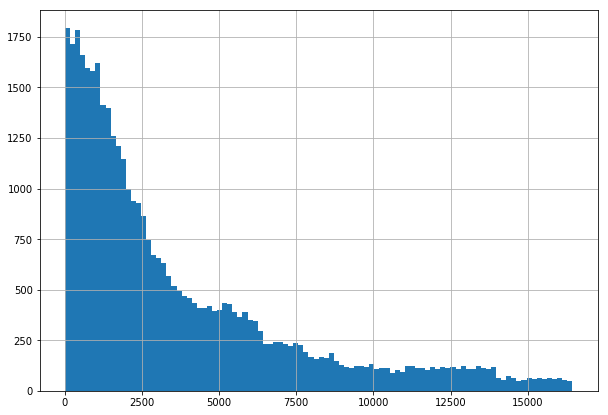

In [413]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

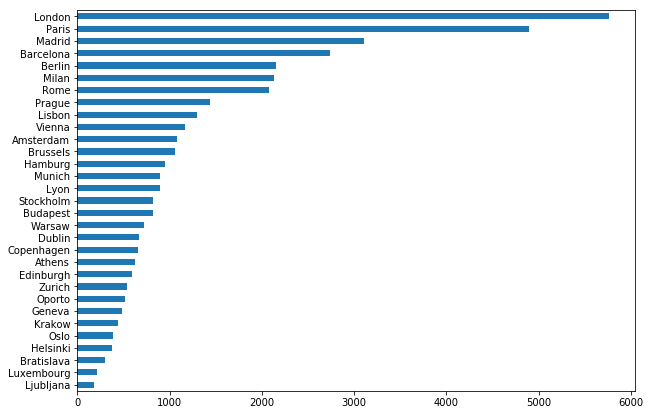

In [414]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

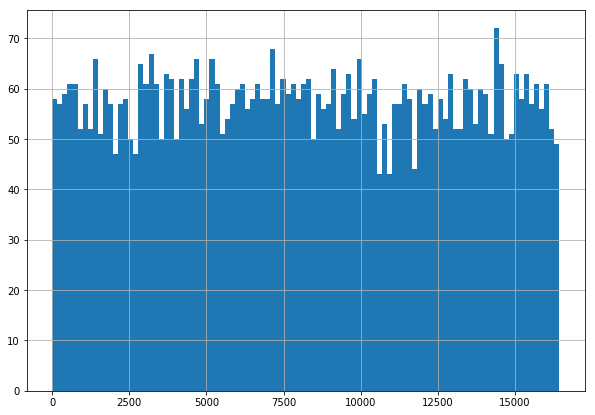

In [415]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

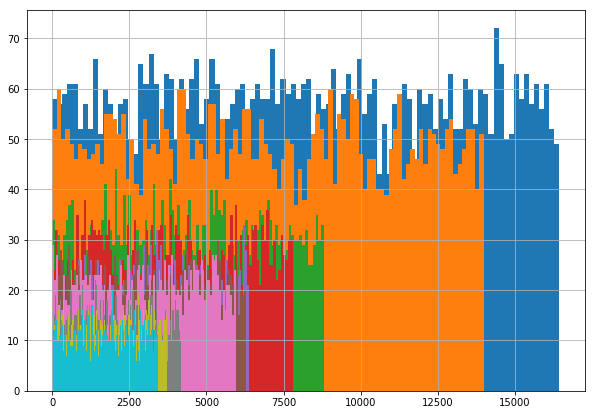

In [416]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

>Подумайте как из этого можно сделать признак для вашей модели. Я покажу вам пример, как визуализация помогает находить взаимосвязи. А далее действуйте без подсказок =) 


### Посмотрим распределение целевой переменной

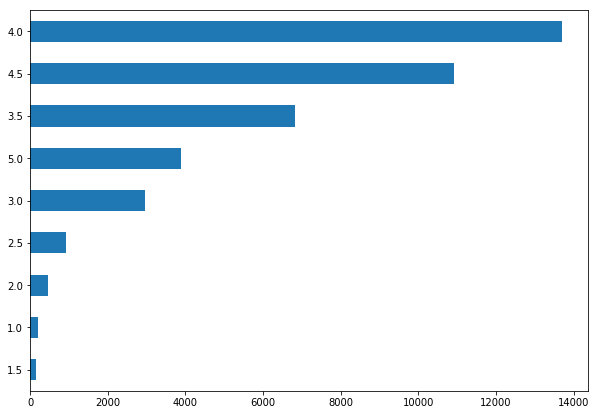

In [417]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

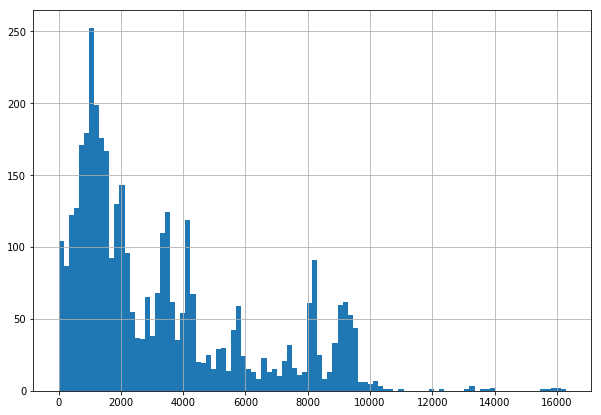

In [418]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

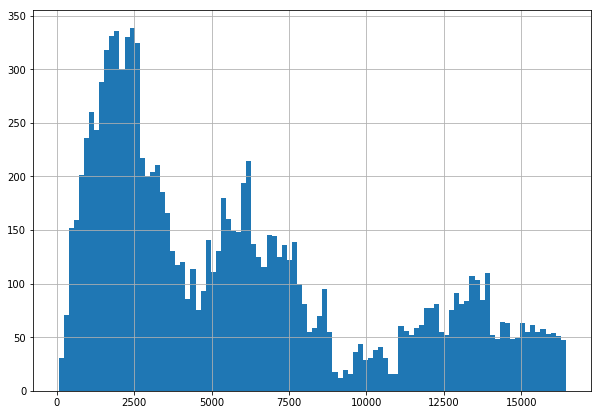

In [419]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

### И один из моих любимых - [корреляция признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

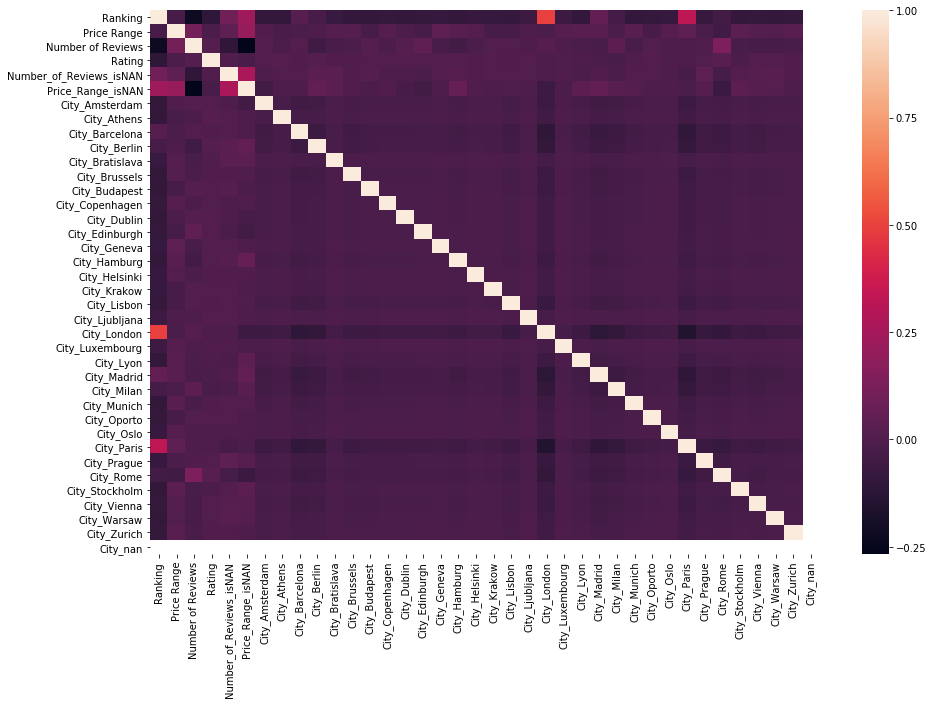

In [420]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

Вообще благодаря визуализации в этом датасете можно узнать много интересных фактов, например:
* где больше Пицерий в Мадриде или Лондоне?
* в каком городе кухня ресторанов более разнообразна?

придумайте свои вопрос и найдите на него ответ в данных)

### Adding features

In [421]:
# 1. Is in a capital?
# data['is_capital'] = data['City'].isin(countries_info['capital'].values).astype('uint8')

In [422]:
# 2. Weighed ranking

# cities_count = data.groupby('City')['Restaurant_id'].count()
# data.apply(get_weighed_rank, rank_table=cities_count, axis=1)

In [423]:
# 3. Gini index

# countries_info[countries_info['capital'].isin(data['City'].unique())]
# cities_info

In [424]:
# for city in data['City'].str.lower().unique():
#     if city not in cities_info['City'].str.lower().unique():
#         print(city)
# np.sort(cities_info['City'].unique())

In [425]:
# 4. Cuisine styles number
data['Cuisine_styles_number'] = data['Cuisine Style'].str.findall('\'(.*?)\'').str.len()

In [426]:
# 5. City population
# cities_info[['City', 'population']].set_index('City').squeeze()
# data['City_population'] = data['City'].replace(to_replace=cities_info[['City', 'population']].set_index('City').squeeze())

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [427]:
# на всякий случай, заново подгружаем данные
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [428]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [429]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
#     df_output.drop(['Restaurant_id','ID_TA',], axis = 1, inplace=True)
    df_output.drop(['ID_TA'], axis = 1, inplace=True)
    
    # ################### 2. NAN ############################################################## 
    # Далее заполняем пропуски, вы можете попробовать заполнением средним или средним по городу и тд...
    # тут ваш код по обработке NAN
#     print("Filling in NaNs in 'Cuisine Style', 'Price Range', 'Number of Reviews' with parsed data...")
    
#     for col in ['Cuisine Style', 'Price Range', 'Number of Reviews']:
# #     for col in ['Cuisine Style', 'Number of Reviews']:
#         df_output[col] = df_output.apply(fillna_parsed, obj=col, axis=1)
#         print(f'{col} finished')
    
    print('\nMarking still missing values...\n')
    df_output['Number_of_Reviews_isNAN'] = pd.isna(data['Number of Reviews']).astype('uint8')
    df_output['Price_Range_isNAN'] = pd.isna(df_output['Price Range']).astype('uint8')
    
    print('Filling them in...\n')
    median_by_city = df_output.groupby('City')['Number of Reviews'].median().round()
    df_output['Number of Reviews'] = df_output.apply(custom_fillna, obj='Number of Reviews', table=median_by_city, axis=1)
    
    df_output['Price Range'].fillna('$$ - $$$', inplace=True)
    
    # ################### 3. Encoding ############################################################## 
    # для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
    print('Encoding features...\n')
#     df_output = pd.get_dummies(df_output, columns=['City'], dummy_na=True)
    # тут ваш код не Encoding фитчей
    
    df_output = cuisine_dummies(df_output)
    
    price_ranges = {'$': 1, '$$ - $$$': 2, '$$$$': 3}
    df_output['Price Range'] = df_output['Price Range'].replace(to_replace=price_ranges)
    
    
    # ################### 4. Feature Engineering ####################################################
    # тут ваш код не генерацию новых фитчей
    print('Feature engineering...\n')
    # 1. Is in a capital?
    df_output['is_capital'] = df_output['City'].isin(countries_info['capital'].values).astype('uint8')
    
    # 2. Weighed ranking
#     cities_max_rank = df_output.groupby('City')['Ranking'].max()
    rest_count = df_output.groupby('City')['Restaurant_id'].count()
    df_output['Weighed_ranking'] = df_output.apply(get_weighed_rank, obj='Ranking', rank_table=rest_count, axis=1)
    
    # 3. Weighed number of reviews
#     cities_max_rev = df_output.groupby('City')['Number of Reviews'].max()
    df_output['Weighed_reviews_num'] = df_output.apply(get_weighed_rank, obj='Number of Reviews', rank_table=rest_count, axis=1)
    
    # 4. Cuisine styles number
    df_output['Cuisine_styles_number'] = df_output['Cuisine Style'].str.findall('\'(.*?)\'').str.len()
    median_by_city = df_output.groupby('City')['Cuisine_styles_number'].median().round()
    df_output['Cuisine_styles_number'] = df_output.apply(custom_fillna, obj='Cuisine_styles_number', table=median_by_city, axis=1)
    
    # 5. City population
    df_output['City_population'] = df_output['City'].replace(to_replace=cities_info[['City', 'population']].set_index('City').squeeze())
    
#     city dummies
    df_output = pd.get_dummies(df_output, columns=['City'], dummy_na=True)
    
    # ################### 5. Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
    object_columns = [s for s in df_output.columns if df_output[s].dtypes == 'object']
    df_output.drop(object_columns, axis = 1, inplace=True)
    
    return df_output

>По хорошему, можно было бы перевести эту большую функцию в класс и разбить на подфункции (согласно ООП). 

#### Запускаем и проверяем что получилось

In [430]:
df_preproc = preproc_data(data)
df_preproc.sample(10)


Marking still missing values...

Filling them in...

Encoding features...

Feature engineering...



,Ranking,Price Range,Number of Reviews,sample,Rating,Number_of_Reviews_isNAN,Price_Range_isNAN,is_capital,Weighed_ranking,Weighed_reviews_num,Cuisine_styles_number,City_population
737,2715.0,3,199.0,0,0.0,0,0,1,0.444499,0.032580,1.0,2110694.0
20197,4697.0,2,25.0,1,4.0,0,0,0,1.383505,0.007364,1.0,1570378.0
21615,2661.0,2,21.0,1,4.0,1,1,1,1.844075,0.014553,1.0,1569315.0
22170,6275.0,2,47.0,1,1.0,1,1,0,2.329250,0.017446,3.0,1156903.0
5245,342.0,2,39.0,0,0.0,0,0,1,0.700820,0.079918,2.0,808690.0
27932,1465.0,2,24.0,1,3.0,0,0,0,2.138686,0.035036,2.0,346185.0
16742,819.0,2,29.0,1,4.5,0,1,0,0.727353,0.025755,1.0,463700.0
9968,12819.0,2,159.0,0,0.0,0,0,1,2.098723,0.026031,4.0,2110694.0
33058,3292.0,1,17.0,1,4.0,0,0,0,0.969661,0.005007,1.0,1570378.0
41476,8589.0,1,44.0,1,3.5,0,0,1,1.194078,0.006117,3.0,7421228.0


In [431]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
Ranking                    50000 non-null float64
Price Range                50000 non-null int64
Number of Reviews          50000 non-null float64
sample                     50000 non-null int64
Rating                     50000 non-null float64
Number_of_Reviews_isNAN    50000 non-null uint8
Price_Range_isNAN          50000 non-null uint8
is_capital                 50000 non-null uint8
Weighed_ranking            50000 non-null float64
Weighed_reviews_num        50000 non-null float64
Cuisine_styles_number      50000 non-null float64
City_population            50000 non-null float64
dtypes: float64(7), int64(2), uint8(3)
memory usage: 3.6 MB


In [432]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [433]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [434]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 11), (40000, 11), (40000, 10), (32000, 10), (8000, 10))

# Model 
Сам ML

In [435]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [436]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [437]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = round_of_rating(model.predict(X_test))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [438]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.2843125


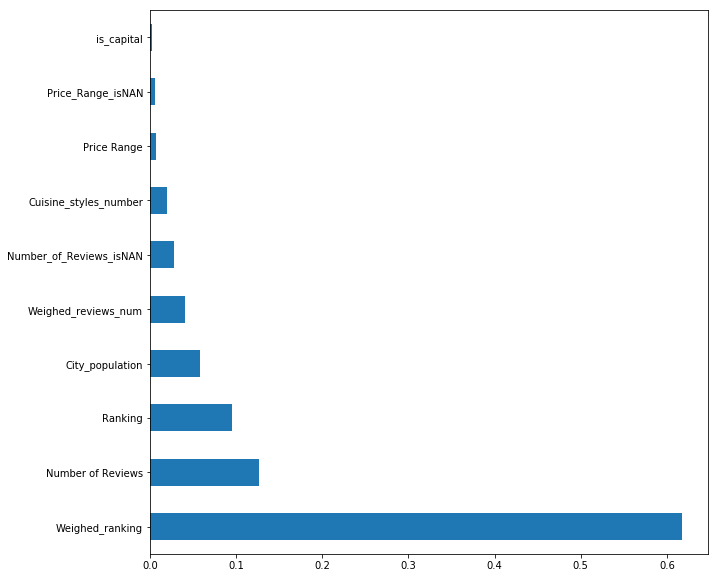

In [439]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [440]:
test_data.sample(10)

,Ranking,Price Range,Number of Reviews,Rating,Number_of_Reviews_isNAN,Price_Range_isNAN,is_capital,Weighed_ranking,Weighed_reviews_num,Cuisine_styles_number,City_population
5520,873.0,2,14.0,0.0,0,0,1,0.943784,0.015135,4.0,1651676.0
5528,1588.0,2,3.0,0.0,0,1,1,1.100485,0.002079,3.0,1569315.0
3412,31.0,2,236.0,0.0,0,0,0,0.026138,0.198988,3.0,1733846.0
234,5375.0,2,23.0,0.0,0,1,1,0.879993,0.003766,1.0,2110694.0
1176,804.0,2,55.0,0.0,0,0,1,0.442731,0.030286,5.0,1154508.0
5145,1260.0,2,2.0,0.0,0,0,1,1.362162,0.002162,1.0,1651676.0
5439,1694.0,2,6.0,0.0,0,1,0,2.273826,0.008054,1.0,435794.0
3995,2247.0,2,7.0,0.0,0,1,1,1.557173,0.004851,3.0,1569315.0
1735,1066.0,2,25.0,0.0,0,0,1,1.301587,0.030525,3.0,1089958.0
900,312.0,1,425.0,0.0,0,0,0,0.418792,0.570470,5.0,435794.0


In [441]:
test_data = test_data.drop(['Rating'], axis=1)

In [442]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [443]:
predict_submission = round_of_rating(model.predict(test_data))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


AttributeError: 'numpy.ndarray' object has no attribute 'apply'

In [ ]:
predict_submission

In [ ]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
